In [1]:
import sys
sys.path.insert(0, '..')

# Obtención de reportes

In [2]:
import controllers as c

In [3]:
rep = c.get_reports(limit=900)
len(rep), rep[:5]

(900,
  <models.Report at 0x7f6423e68a90>])

In [4]:
# search reports with dupe_of not null
reports = []

for r in rep:
    if r.dupe_of is not None:
        try:
            master = c.get_report(r.dupe_of)
            reports.append(r)
        except Exception as e:
            print(e)
            continue
    else:
        reports.append(r)

len(reports), reports[:5]

Report '1586255' not found
Report '1596587' not found
Report '1455054' not found
Report '1389711' not found
Report '116916' not found
Report '735532' not found
Report '1319053' not found
Report '1235283' not found


(892,
  <models.Report at 0x7f6423e68a90>])

In [5]:
columns = [c for c in list(reports[0].__dict__.keys()) if c != '_id']
columns

['report_id',
 'creation_time',
 'status',
 'component',
 'dupe_of',
 'summary',
 'comments']

In [6]:
import pandas as pd
df_reports = pd.DataFrame(columns=columns, data=[r.__dict__ for r in reports])
df_reports.head()

,report_id,creation_time,status,component,dupe_of,summary,comments
0,1775851,2022-06-22 20:30:23,NEW,New Tab Page,NaN,Intermittent browser/components/newtab/test/br...,
1,1775776,2022-06-22 20:08:18,NEW,Protections UI,NaN,Intermittent browser/components/protections/te...,
2,1775671,2022-06-22 19:38:28,NEW,Toolbars and Customization,NaN,Intermittent browser/components/customizableui...,
3,1775632,2022-06-22 19:28:36,NEW,Tabbed Browser,NaN,Intermittent browser/base/content/test/perform...,
4,1771460,2022-05-27 09:21:04,RESOLVED,General,NaN,Conflicting global variable and lazy getter,There are some case that `Services` is importe...


In [7]:
for i, row in df_reports.iterrows():
    summary = row['summary']
    comments = row['comments']
    if len(summary) <= 100 and len(comments) <= 1000:
        text = summary + ' ' + comments
    else:
        text = summary
    df_reports.loc[i, 'text'] = text

df_reports.head()

,report_id,creation_time,status,component,dupe_of,summary,comments,text
0,1775851,2022-06-22 20:30:23,NEW,New Tab Page,NaN,Intermittent browser/components/newtab/test/br...,,Intermittent browser/components/newtab/test/br...
1,1775776,2022-06-22 20:08:18,NEW,Protections UI,NaN,Intermittent browser/components/protections/te...,,Intermittent browser/components/protections/te...
2,1775671,2022-06-22 19:38:28,NEW,Toolbars and Customization,NaN,Intermittent browser/components/customizableui...,,Intermittent browser/components/customizableui...
3,1775632,2022-06-22 19:28:36,NEW,Tabbed Browser,NaN,Intermittent browser/base/content/test/perform...,,Intermittent browser/base/content/test/perform...
4,1771460,2022-05-27 09:21:04,RESOLVED,General,NaN,Conflicting global variable and lazy getter,There are some case that `Services` is importe...,Conflicting global variable and lazy getter Th...


In [8]:
df_reports.summary

0      Intermittent browser/components/newtab/test/br...
1      Intermittent browser/components/protections/te...
2      Intermittent browser/components/customizableui...
3      Intermittent browser/base/content/test/perform...
4            Conflicting global variable and lazy getter
                             ...                        
887    Should not display more than one "Master Passw...
888    eternal/endless/infinite loop when associating...
889    Limit Scope of Session Cookies (new tabs and w...
890    CSS not fixed up by webbrowserpersist ("save p...
891        Cookies need to be encrypted via one-way hash
Name: summary, Length: 892, dtype: object

# Preprocesamiento

In [9]:
from nltk.corpus import stopwords

CUSTOM_STOPWORDS = ['info']

def remove_stopwords(sentence: list) -> list:
    return [w for w in sentence if w not in stopwords.words('english') + CUSTOM_STOPWORDS]

In [10]:
from string import punctuation
EXTRA_CHARACTERS = [p for p in punctuation if p not in list('_')]
ALLOWED_URL_CHARS = [':', '/', '?', '=', '&', '#']
URL_FORBIDDEN_CHARS = [c for c in EXTRA_CHARACTERS if c not in ALLOWED_URL_CHARS]

In [11]:
def process_token(token: str) -> list:
    if token.isdigit():
        return []

    token = token.lower()

    if token.startswith('http'):
        token = ''.join([w if w not in URL_FORBIDDEN_CHARS else '' for w in token])
    else:
        token = ''.join([w if w not in EXTRA_CHARACTERS else ' ' for w in token])

    token = token.strip()

    return token.split() if len(token.split()) > 1 else [token]

In [12]:
def remove_extra_characters(sentence: str) -> list:

    sentence_to_process = sentence.split() # Generar tokens por espacios
    sentence_processed = []

    # Eliminar tokens que sean solo números
    sentence_processed = [w for w in sentence_to_process if not w.isdigit()]
    # Eliminar tokens que sean solo puntuación
    sentence_processed = [w for w in sentence_processed if w not in list(punctuation)]

    result = []
    for w in sentence_processed:
        token = process_token(w)
        if len(token) > 1:
            for subtoken in token:
                result.extend(process_token(subtoken))
        else:
            result.extend(token)
    
    return result

In [13]:
# Lematize words
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()

def lemmatize(sentence: list) -> list:
    return [LEMMATIZER.lemmatize(w) for w in sentence]

[nltk_data] Downloading package omw-1.4 to /home/ajburri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
def preprocess(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = lemmatize(p_sentence)
    # Unir en una sola cadena
    p_sentence = ' '.join(p_sentence)
    return p_sentence

In [15]:
print(df_reports['text'][0])
print(preprocess(df_reports['text'][0]))

Intermittent browser/components/newtab/test/browser/browser_asrouter_group_frequency.js | single tracking bug
intermittent browser component newtab test browser browser_asrouter_group_frequency j single tracking bug


In [16]:
df_reports['tokens'] = df_reports['text'].apply(preprocess)
df_reports.head()

,report_id,creation_time,status,component,dupe_of,summary,comments,text,tokens
0,1775851,2022-06-22 20:30:23,NEW,New Tab Page,NaN,Intermittent browser/components/newtab/test/br...,,Intermittent browser/components/newtab/test/br...,intermittent browser component newtab test bro...
1,1775776,2022-06-22 20:08:18,NEW,Protections UI,NaN,Intermittent browser/components/protections/te...,,Intermittent browser/components/protections/te...,intermittent browser component protection test...
2,1775671,2022-06-22 19:38:28,NEW,Toolbars and Customization,NaN,Intermittent browser/components/customizableui...,,Intermittent browser/components/customizableui...,intermittent browser component customizableui ...
3,1775632,2022-06-22 19:28:36,NEW,Tabbed Browser,NaN,Intermittent browser/base/content/test/perform...,,Intermittent browser/base/content/test/perform...,intermittent browser base content test perform...
4,1771460,2022-05-27 09:21:04,RESOLVED,General,NaN,Conflicting global variable and lazy getter,There are some case that `Services` is importe...,Conflicting global variable and lazy getter Th...,conflicting global variable lazy getter case s...


# TFIDF

In [17]:
df_reports.shape, df_reports.columns

((892, 9),
 Index(['report_id', 'creation_time', 'status', 'component', 'dupe_of',
        'summary', 'comments', 'text', 'tokens'],
       dtype='object'))

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True)
df_reports['str_tokens'] = df_reports['tokens']
X = tfidf_vectorizer.fit_transform(df_reports['str_tokens'])

In [19]:
X.toarray().shape, len(tfidf_vectorizer.get_feature_names())

/home/ajburri/.local/share/virtualenvs/backend-Te0t6uJi/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((892, 4883), 4883)

#### Pruebas

In [20]:
tmp_vec = TfidfVectorizer(sublinear_tf=True, use_idf=True)
tmp_X = tmp_vec.fit_transform(df_reports['str_tokens'])

In [21]:
len(tmp_vec.get_feature_names()), tmp_X.toarray().shape

(4883, (892, 4883))

In [22]:
tmp_X.toarray()[0].shape

(4883,)

# Kmeans

In [23]:
df_duplicates = df_reports[df_reports['dupe_of'].notnull()]
df_masters = df_reports[df_reports['dupe_of'].isnull()]

In [24]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

RANGE_CLUSTERS = range(1,51)
kmeans = [KMeans(n_clusters=i).fit(tmp_X) for i in RANGE_CLUSTERS]

In [25]:
scores = [kmeans[i].score(tmp_X) for i in range(len(kmeans))]
inertias = [kmeans[i].inertia_ for i in range(len(kmeans))]
dfs = []

for k in kmeans:
    df = df_reports.copy()
    df['cluster'] = k.labels_
    dfs.append(df)

In [26]:
# calculate accuracy for each n of clusters
from sklearn.metrics import accuracy_score

accuracies = []

for df in dfs: # each df with N clusters
    df_duplicates = df[df['dupe_of'].notnull()]
    df_masters = df[df['dupe_of'].isnull()]
    
    master_clusters = []
    for i, row in df_duplicates.iterrows():
        master_id = row['dupe_of']
        master_cluster = df_masters.loc[df_masters['report_id'] == master_id, 'cluster'].values
        if len(master_cluster) > 0:
            master_clusters.append(master_cluster[0])
        else:
            print(f"No master cluster found for {master_id}")
    
    accuracies.append(accuracy_score(master_clusters, df_duplicates['cluster']))


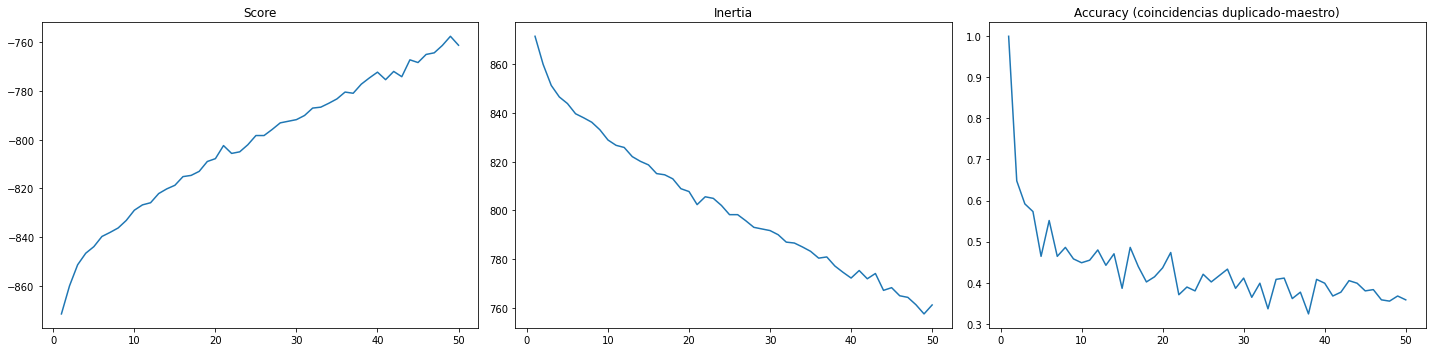

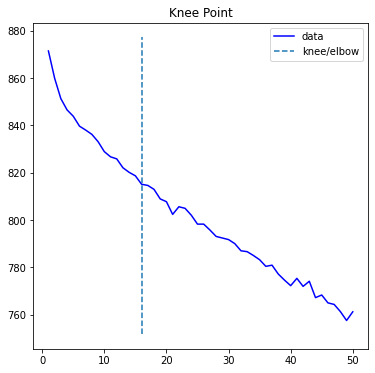

Número óptimo de clusters según elbow method: 16
Número de clusters para máxima accuracy:
	· 1.000% - 1 clusteres
	· 0.648% - 2 clusteres
	· 0.592% - 3 clusteres
	· 0.573% - 4 clusteres
	· 0.551% - 6 clusteres
	· 0.486% - 8 clusteres
	· 0.486% - 8 clusteres
	· 0.480% - 12 clusteres
	· 0.474% - 21 clusteres
	· 0.470% - 14 clusteres
	· 0.464% - 5 clusteres
	· 0.464% - 5 clusteres
	· 0.458% - 9 clusteres
	· 0.455% - 11 clusteres
	· 0.449% - 10 clusteres


In [27]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(RANGE_CLUSTERS, scores)
ax[0].set_title('Score')
ax[1].plot(RANGE_CLUSTERS, inertias)
ax[1].set_title('Inertia')
ax[2].plot(RANGE_CLUSTERS, accuracies)
ax[2].set_title('Accuracy (coincidencias duplicado-maestro)')

fig.tight_layout()
plt.show()

knee = KneeLocator(RANGE_CLUSTERS, inertias, curve='convex', direction='decreasing')
opt_n_clusters = knee.knee
knee.plot_knee()
plt.show()

print(f'Número óptimo de clusters según elbow method: {opt_n_clusters}')
# Get index of 3 best accuracies
best_accuracies = sorted(accuracies, reverse=True)[:15]
print(f"Número de clusters para máxima accuracy:")
for acc in best_accuracies:
    print(f"\t· {acc:.3f}% - {RANGE_CLUSTERS[accuracies.index(acc)]} clusteres")

## Modelo

In [37]:
# OPT_N_CLUSTERS = opt_n_clusters
OPT_N_CLUSTERS = 16

In [38]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=OPT_N_CLUSTERS, random_state=42)
# fit the model
model.fit(tmp_X)
# store cluster labels in a variable
clusters = model.labels_

In [39]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tmp_X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [40]:
df_reports['cluster'] = clusters
df_reports['x0'] = x0
df_reports['x1'] = x1

In [41]:
import numpy as np
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = tfidf_vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        # print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0

Cluster 1

Cluster 2

Cluster 3

Cluster 4

Cluster 5

Cluster 6

Cluster 7

Cluster 8

Cluster 9

Cluster 10

Cluster 11

Cluster 12

Cluster 13

Cluster 14

Cluster 15


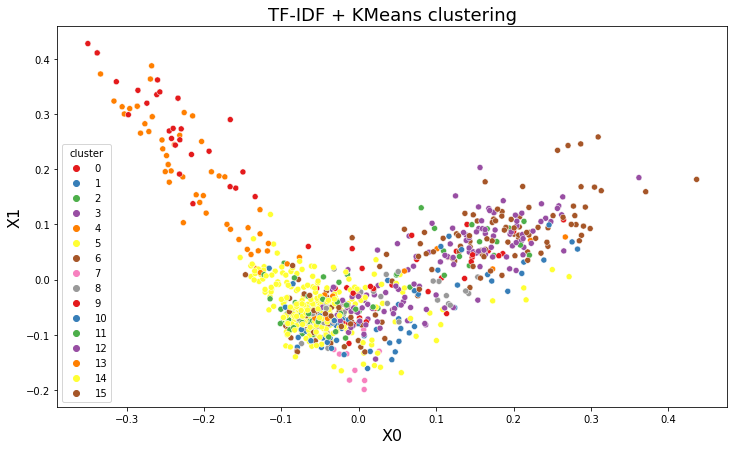

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_reports, x='x0', y='x1', hue='cluster', palette="Set1")
plt.show()

### Comprobar duplicado+maestro segun clusters

In [46]:
df_duplicates = df_reports[df_reports['dupe_of'].notnull()]
df_masters = df_reports[df_reports['dupe_of'].isnull()]

master_clusters = []
for i, row in df_duplicates.iterrows():
    master_id = row['dupe_of']
    master_cluster = df_masters.loc[df_masters['report_id'] == master_id, 'cluster'].values
    if len(master_cluster) > 0:
        master_clusters.append(master_cluster[0])
    else:
        print(f"No master cluster found for {master_id}")

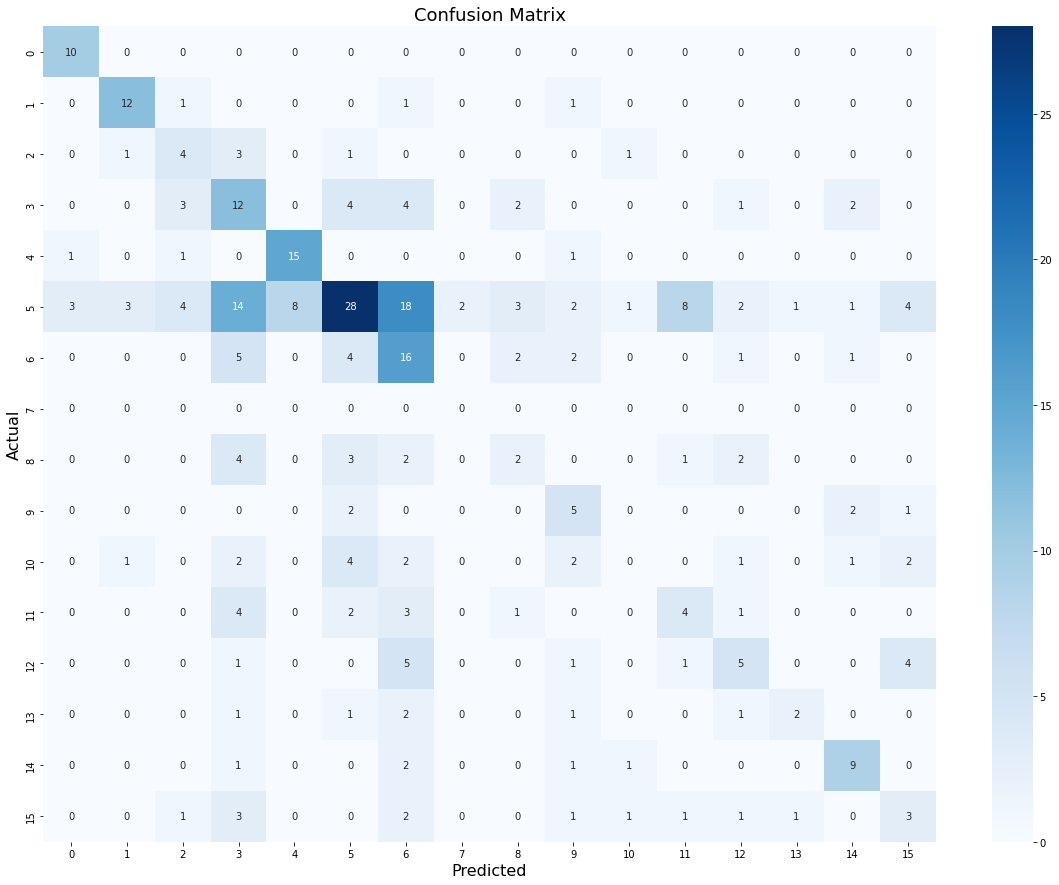

In [47]:
from sklearn.metrics import confusion_matrix

# plot confussion_matrix    
cm = confusion_matrix(master_clusters, df_duplicates['cluster'].values)
plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", fontdict={"fontsize": 18})
plt.xlabel("Predicted", fontdict={"fontsize": 16})
plt.ylabel("Actual", fontdict={"fontsize": 16})
plt.show()

In [48]:
# Calculate the accuracy of the model
from sklearn.metrics import classification_report
print(classification_report(master_clusters, df_duplicates['cluster'].values, zero_division=0))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.71      0.80      0.75        15
           2       0.29      0.40      0.33        10
           3       0.24      0.43      0.31        28
           4       0.65      0.83      0.73        18
           5       0.57      0.27      0.37       102
           6       0.28      0.52      0.36        31
           7       0.00      0.00      0.00         0
           8       0.20      0.14      0.17        14
           9       0.29      0.50      0.37        10
          10       0.00      0.00      0.00        15
          11       0.27      0.27      0.27        15
          12       0.33      0.29      0.31        17
          13       0.50      0.25      0.33         8
          14       0.56      0.64      0.60        14
          15       0.21      0.21      0.21        14

    accuracy                           0.40       321
   macro avg       0.36   